<a href="https://www.kaggle.com/code/faisalalbasu/spectrogram-windows-test?scriptVersionId=139676541" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import balanced_accuracy_score as bal_acc
from sklearn.metrics import f1_score as f1
import sklearn.metrics
import scipy.stats as stats
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

!pip install dtreeviz
from dtreeviz.trees import *
import dtreeviz

try:
    import joblib
except:
    !pip install joblib
finally:
    import joblib

# plt.style.use('seaborn')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.1 MB/s eta 0:00:00


In [2]:
# small sampled data
# !wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/sample%20analysis.csv'

In [3]:
# small sample with diagnoses
# !wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/sample_analysis_diagnoses.csv'

In [4]:
# full data for maximimum signals
!wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum.csv'

--2023-08-12 06:08:20--  https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 859432 (839K) [text/plain]
Saving to: ‘maximum.csv’

maximum.csv         100%[===================>] 839.29K  --.-KB/s    in 0.03s   

2023-08-12 06:08:20 (32.5 MB/s) - ‘maximum.csv’ saved [859432/859432]



In [5]:
# full data with diagnoses
!wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum_diagnoses.csv'

--2023-08-12 06:08:21--  https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum_diagnoses.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5623 (5.5K) [text/plain]
Saving to: ‘maximum_diagnoses.csv’

maximum_diagnoses.c 100%[===================>]   5.49K  --.-KB/s    in 0s      

2023-08-12 06:08:21 (42.4 MB/s) - ‘maximum_diagnoses.csv’ saved [5623/5623]



In [6]:
max_erg = pd.read_csv('/kaggle/working/maximum.csv', sep = ',', index_col = 'Time,ms')
max_erg.head()

,3,3.1,5,6,6.1,6.2,7,10,11,15,...,1880,1931,1961,1961.1,1962,1962.1,1963,1963.1,1964,1964.1
"Time,ms",,,,,,,,,,,,,,,,,,,,,
0.0,0.000004,-2.35,0.000013,-10.8,1.150000e-06,0.000003,-3.466499,-8.67,1.320000e-06,-3.10,...,0.000025,0.000029,-2.076184,-7.590125,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
0.5,0.000004,-2.47,0.000012,-11.1,9.600000e-07,0.000003,-3.523260,-9.02,1.120000e-06,-3.45,...,0.000025,0.000029,-2.106670,-7.468806,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
1.0,0.000004,-2.63,0.000012,-11.5,7.460000e-07,0.000002,-3.602958,-9.39,9.050000e-07,-3.83,...,0.000025,0.000028,-2.131098,-7.339658,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
1.5,0.000004,-2.80,0.000012,-11.9,5.060000e-07,0.000002,-3.705310,-9.79,6.810000e-07,-4.25,...,0.000025,0.000028,-2.149734,-7.204155,0.000002,0.000002,0.000022,0.000019,0.000016,0.00002
2.0,0.000003,-3.01,0.000012,-12.4,2.440000e-07,0.000001,-3.829635,-10.20,4.460000e-07,-4.70,...,0.000025,0.000027,-2.162955,-7.063886,0.000002,0.000002,0.000022,0.000019,0.000016,0.00002


In [7]:
diag_max_erg = pd.read_csv('/kaggle/working/maximum_diagnoses.csv', sep = ',')
diag_max_erg

,Unnamed: 0,3,3.1,5,6,6.1,6.2,7,10,11,...,1880,1931,1961,1961.1,1962,1962.1,1963,1963.1,1964,1964.1
0,Diagnosis,unhealthy,healthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,...,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy,unhealthy


In [8]:
diag_max_erg.drop('Unnamed: 0', axis = 1, inplace = True)

In [9]:
# data = pd.read_csv('/kaggle/working/sample analysis.csv', sep = ',', index_col='Time,ms')
# data

In [10]:
# diagdata = pd.read_csv('/kaggle/working/sample_analysis_diagnoses.csv', sep = ',')
# diagdata

In [11]:
# diagdata.drop('Unnamed: 0', axis = 1, inplace = True)
# diagdata

In [12]:
NFFTS = [128, 64, 32, 16, 8, 4]
overlaps = [64, 32, 16, 8, 4, 2]
windows = ['hann', 'hamming', 'blackman', 'tukey', 'boxcar', 'bartlett', 'blackmanharris', 'taylor']

In [13]:
def plot_spectrogram(sig: str, nfft, noverlap, colormap):
    time_step = 0.005 # in seconds
    sample_freq = 1 / time_step
    sig = np.array(max_erg[sig])
    
    assert sig.ndim  == 1
    assert nfft <= len(sig)
    
#     window = np.blackman(nfft)
    window = signal.get_window('taylor', nfft)
    
    Sxx, freqs, bins, im = plt.specgram(sig, Fs = sample_freq, NFFT = nfft, noverlap = noverlap, cmap = colormap, window = window)
    plt.colorbar().set_label('Power')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()
    return Sxx

In [14]:
# a = plot_spectrogram('3', 32, 16, 'jet')
# a

In [15]:
def load_signal(sig):
    assert type(sig) is str, f"{type(sig)}"
    signal_no = np.array(max_erg[sig])
    return signal_no

In [16]:
def compute_spectrogram(signal_no, nperseg, noverlap, window):
    time_step = 0.005
    sample_freq = 1 / time_step
    freqs, times, Sxx = scipy.signal.spectrogram(signal_no, fs = sample_freq, nperseg = nperseg, noverlap = noverlap, window = window)
    
    return freqs, times, Sxx

In [17]:
# def divide_quadrants(Sxx):
#     num_t, num_f = Sxx.shape
#     quadrant1 = Sxx[:num_t//2, :num_f//2]  # Top-left quadrant
#     quadrant2 = Sxx[:num_t//2, num_f//2:]  # Top-right quadrant
#     quadrant3 = Sxx[num_t//2:, :num_f//2]  # Bottom-left quadrant
#     quadrant4 = Sxx[num_t//2:, num_f//2:]  # Bottom-right quadrant
#     print(quadrant1, quadrant2, quadrant3, quadrant4)
#     return quadrant1, quadrant2, quadrant3, quadrant4

In [18]:
# a = np.linspace(0, 50)
# b = np.reshape(a, (5, 10))
# c, d = b.shape
# b[:c//2]

In [19]:
def compute_features(sig, nperseg, noverlap, window):
    freqs, times, Sxx = compute_spectrogram(signal_no, nperseg, noverlap, window)
    spectrum = Sxx.flatten()
    bmin = np.min(spectrum)
    bmedian = np.median(spectrum)
    bmax = np.max(spectrum)
    bmean = np.mean(spectrum)
    return bmin, bmedian, bmax, bmean

I've tried dividing the spectrogram into quadrants but I keep getting issue where some of the quadrants would return empty arrays, so I've given up on that for now.

In [20]:
# def get_features(sig, nperseg, noverlap, window):
#     signal_no = load_signal(sig)
#     freqs, times, Sxx = compute_spectrogram(signal_no, nperseg, noverlap, window)
#     quadrant1, quadrant2, quadrant3, quadrant4 = divide_quadrants(Sxx)
#     q1bmin, q1bmedian, q1bmax, q1bmean = compute_features(quadrant1)
#     q2bmin, q2bmedian, q2bmax, q2bmean = compute_features(quadrant2)
#     q3bmin, q3bmedian, q3bmax, q3bmean = compute_features(quadrant3)
#     q4bmin, q4bmedian, q4bmax, q4bmean = compute_features(quadrant4)
#     return q1bmin, q1bmedian, q1bmax, q1bmean, q2bmin, q2bmedian, q2bmax, q2bmean, q3bmin, q3bmedian, q3bmax, q3bmean, q4bmin, q4bmedian, q4bmax, q4bmean

In [21]:
# def get_features(sig, nperseg, noverlap, window):
#     freqs, times, Sxx = compute_spectrogram(sig = sig, nperseg = nperseg, noverlap = noverlap, window = window)
#     num_t, num_f = Sxx.shape
#     quadrant1 = Sxx[:num_t//2, :num_f//2]  # Top-left quadrant
#     quadrant2 = Sxx[:num_t//2, num_f//2:]  # Top-right quadrant
#     quadrant3 = Sxx[num_t//2:, :num_f//2]  # Bottom-left quadrant
#     quadrant4 = Sxx[num_t//2:, num_f//2:]  # Bottom-right quadrant
# #     print(f"q1: {quadrant1}, q2: {quadrant2}, q3: {quadrant3}, q4: {quadrant4}")

#      # Check if any quadrant is empty
#     assert quadrant1.size > 0, f"Top-left quadrant of {sig} is empty."
#     assert quadrant2.size > 0, f"Top-right quadrant of {sig} is empty."
#     assert quadrant3.size > 0, f"Bottom-left quadrant of {sig} is empty."
#     assert quadrant4.size > 0, f"Bottom-right quadrant of {sig} is empty."
    
#     q1spectrum = quadrant1.flatten()
#     q2spectrum = quadrant2.flatten()
#     q3spectrum = quadrant3.flatten()
#     q4spectrum = quadrant4.flatten()
    
#     # Check if any spectrum is empty after flattening
# #     assert q1spectrum.size > 0, "Top-left spectrum is empty."
# #     assert q2spectrum.size > 0, "Top-right spectrum is empty."
# #     assert q3spectrum.size > 0, "Bottom-left spectrum is empty."
# #     assert q4spectrum.size > 0, "Bottom-right spectrum is empty."
# #     print(f"q1s: {q1spectrum}, q2s: {q2spectrum}, q3s: {q3spectrum}, q4s: {q4spectrum}")

# #     if len(q1spectrum) == 0:
# #         print(f"empty array at {sig}, {q1spectrum}, {quadrant1}")
# #         return

#   # Compute features for each quadrant
#     q1bmin, q1bmedian, q1bmax, q1bmean = np.min(q1spectrum), np.median(q1spectrum), np.max(q1spectrum), np.mean(q1spectrum)
#     q2bmin, q2bmedian, q2bmax, q2bmean = np.min(q2spectrum), np.median(q2spectrum), np.max(q2spectrum), np.mean(q2spectrum)
#     q3bmin, q3bmedian, q3bmax, q3bmean = np.min(q3spectrum), np.median(q3spectrum), np.max(q3spectrum), np.mean(q3spectrum)
#     q4bmin, q4bmedian, q4bmax, q4bmean = np.min(q4spectrum), np.median(q4spectrum), np.max(q4spectrum), np.mean(q4spectrum)
    
# #     print(f"{sig} q1s: {q1spectrum}, q2s: {q2spectrum}, q3s: {q3spectrum}, q4s: {q4spectrum}")
# #     print(f"q1s shape: {q1spectrum.shape}, q2s shape: {q2spectrum.shape}, q3s shape: {q3spectrum.shape}, q4s shape: {q4spectrum.shape}")

    
#     return q1bmin, q1bmedian, q1bmax, q1bmean, q2bmin, q2bmedian, q2bmax, q2bmean, q3bmin, q3bmedian, q3bmax, q3bmean, q4bmin, q4bmedian, q4bmax, q4bmean

In [22]:
# for column in max_erg.columns:
#     if len(column) == 0:
#         print(f"empty array at {column}")
#     print(get_features(column, 32, 16, 'tukey'))

# get_features('6.1', 32, 16, 'tukey')

In [23]:
# def get_parameters():
#     size, overlap, name = None, None, None
#     for n in NFFTS:
#         size = n
#     for o in overlaps:
#         overlap = o
#     for w in windows:
#         name = w
#     # use random.choice instead of loop
#     # then loop through the signals instead
#     return size, overlap, name

# print(get_parameters())

In [24]:
import random
def get_parameters():
    window_type = random.choice(windows)
    
    window_size = random.choice(NFFTS)

    overlap = random.choice(overlaps)
    
    while overlap >= window_size:
        overlap = random.choice(overlaps)

#     if overlap >= window_size:
#         window_size = random.choice(NFFTS)
#         overlap = random.choice(overlaps)
#     else:
#         return window_size, overlap, window_type
#         print(window_size, overlap, window_type)


    
    return window_size, overlap, window_type

#     print(window_size, overlap, window_type)
    
# get_parameters()

In [25]:
dfeatures = pd.DataFrame(columns = ['params', 'Bmin', 'Bmedian', 'Bmax', 'Bmean', 'pat_no'])
dfeatures

,params,Bmin,Bmedian,Bmax,Bmean,pat_no


In [26]:
max_erg.columns

Index(['3', '3.1', '5', '6', '6.1', '6.2', '7', '10', '11', '15',
       ...
       '1880', '1931', '1961', '1961.1', '1962', '1962.1', '1963', '1963.1',
       '1964', '1964.1'],
      dtype='object', length=414)

In [27]:
window_size, overlap, window_type = get_parameters()
for col in max_erg.columns:

    signal_no = load_signal(col)
#     freqs, times, Sxx = compute_spectrogram(signal_no, nperseg = window_size, noverlap = overlap, window = window_type)
    bmin, bmedian, bmax, bmean = compute_features(signal_no, window_size, overlap, window_type)

    # Create a dictionary with the features
    features_dict = {
        'params': f"{window_type}{window_size}{overlap}",
        'Bmin': bmin,
        'Bmedian': bmedian,
        'Bmax': bmax,
        'Bmean': bmean,
        'pat_no': col
    }

    features = pd.DataFrame(features_dict, index = range(0, len(features_dict)))

    dfeatures = pd.concat([dfeatures, features], ignore_index = True)

In [28]:
dfeatures

,params,Bmin,Bmedian,Bmax,Bmean,pat_no
0,bartlett168,2.325581e-20,1.262554e-16,3.736745e-12,8.424678e-14,3
1,bartlett168,2.325581e-20,1.262554e-16,3.736745e-12,8.424678e-14,3
2,bartlett168,2.325581e-20,1.262554e-16,3.736745e-12,8.424678e-14,3
3,bartlett168,2.325581e-20,1.262554e-16,3.736745e-12,8.424678e-14,3
4,bartlett168,2.325581e-20,1.262554e-16,3.736745e-12,8.424678e-14,3
...,...,...,...,...,...,...
2479,bartlett168,2.669637e-45,9.852793e-17,4.278990e-12,8.521416e-14,1964.1
2480,bartlett168,2.669637e-45,9.852793e-17,4.278990e-12,8.521416e-14,1964.1
2481,bartlett168,2.669637e-45,9.852793e-17,4.278990e-12,8.521416e-14,1964.1
2482,bartlett168,2.669637e-45,9.852793e-17,4.278990e-12,8.521416e-14,1964.1


In [29]:
dfeatures.drop_duplicates(inplace = True)
dfeatures.reset_index(drop = True, inplace = True)

In [30]:
# for col in max_erg.columns:
#     window_size, overlap, window_type = get_parameters()
#     signal_no = load_signal(col)
#     freqs, times, Sxx = compute_spectrogram(signal_no, nperseg = window_size, noverlap = overlap, window = window_type)
#     quadrant1, quadrant2, quadrant3, quadrant4 = divide_quadrants(Sxx)
#     q1bmin, q1bmedian, q1bmax, q1bmean = compute_features(quadrant1)
#     q2bmin, q2bmedian, q2bmax, q2bmean = compute_features(quadrant2)
#     q3bmin, q3bmedian, q3bmax, q3bmean = compute_features(quadrant3)
#     q4bmin, q4bmedian, q4bmax, q4bmean = compute_features(quadrant4)
    
#     features = {
#         'Params': f'{window_type}{window_size}{overlap}',
#         'Q1_Min': q1bmin,
#         'Q1_Median': q1bmedian,
#         'Q1_Max': q1bmax,
#         'Q1_Mean': q1bmean,
#         'Q2_Min': q2bmin,
#         'Q2_Median': q2bmedian,
#         'Q2_Max': q2bmax,
#         'Q2_Mean': q2bmean,
#         'Q3_Min': q3bmin,
#         'Q3_Median': q3bmedian,
#         'Q3_Max': q3bmax,
#         'Q3_Mean': q3bmean,
#         'Q4_Min': q4bmin,
#         'Q4_Median': q4bmedian,
#         'Q4_Max': q4bmax,
#         'Q4_Mean': q4bmean
#     }
    
#     dfeatures = dfeatures.append(features, ignore_index = True)

In [31]:
# for _ in range(len(max_erg.columns)):
#     window_size, overlap, window_type = get_parameters()
#     for col in max_erg.columns:
        
#         q1bmin, q1bmedian, q1bmax, q1bmean, q2bmin, q2bmedian, q2bmax, q2bmean, q3bmin, q3bmedian, q3bmax, q3bmean, q4bmin, q4bmedian, q4bmax, q4bmean = get_features(str(col), window_size, overlap, window_type)
        
#         new_dict = {'params': f'{window_type}{window_size}{overlap}', 'q1bmin': q1bmin, 'q1bmedian': q1bmedian, 'q1bmax': q1bmax, 'q1bmean': q1bmax, 'q2bmin': q2bmin, 'q2bmedian': q2bmedian, 'q2bmax': q2bmax, 'q2bmean': q2bmax, 'q3bmin': q3bmin, 'q3bmedian': q3bmedian, 'q3bmax': q3bmax, 'q3bmean': q3bmax, 'q4bmin': q4bmin, 'q4bmedian': q4bmedian, 'q4bmax': q4bmax, 'q4bmean': q4bmax, 'pat_no': col}
#         new_features = pd.DataFrame(data = new_dict, index = range(0, len(new_dict)))
#     dfeatures = pd.concat([dfeatures, new_features], ignore_index = True)

In [32]:
dfeatures

,params,Bmin,Bmedian,Bmax,Bmean,pat_no
0,bartlett168,2.325581e-20,1.262554e-16,3.736745e-12,8.424678e-14,3
1,bartlett168,2.436225e-08,1.214899e-04,4.910695e+00,9.669949e-02,3.1
2,bartlett168,5.232558e-20,9.513970e-17,2.359237e-12,5.752205e-14,5
3,bartlett168,1.593202e-07,5.110799e-04,2.502996e+01,5.091734e-01,6
4,bartlett168,2.943314e-20,9.470386e-17,4.171300e-12,8.534332e-14,6.1
...,...,...,...,...,...,...
409,bartlett168,1.453488e-21,1.497475e-18,3.147439e-14,1.104386e-15,1962.1
410,bartlett168,2.669637e-45,3.776617e-17,4.367561e-13,1.561434e-14,1963
411,bartlett168,2.669637e-45,2.658249e-17,3.877171e-13,1.378960e-14,1963.1
412,bartlett168,1.668523e-46,5.994826e-17,2.550046e-12,5.061235e-14,1964


In [33]:
max_erg.columns

Index(['3', '3.1', '5', '6', '6.1', '6.2', '7', '10', '11', '15',
       ...
       '1880', '1931', '1961', '1961.1', '1962', '1962.1', '1963', '1963.1',
       '1964', '1964.1'],
      dtype='object', length=414)

In [34]:
# # dfeatures_list = []
# for col in max_erg.columns:
#     window_size, overlap, window_type = get_parameters()
#     q1bmin, q1bmedian, q1bmax, q1bmean, q2bmin, q2bmedian, q2bmax, q2bmean, q3bmin, q3bmedian, q3bmax, q3bmean, q4bmin, q4bmedian, q4bmax, q4bmean = get_features(str(col), window_size, overlap, window_type)
        
#     new_dict = {'params': f'{window_type}{window_size}{overlap}', 'q1bmin': q1bmin, 'q1bmedian': q1bmedian, 'q1bmax': q1bmax, 'q1bmean': q1bmax, 'q2bmin': q2bmin, 'q2bmedian': q2bmedian, 'q2bmax': q2bmax, 'q2bmean': q2bmax, 'q3bmin': q3bmin, 'q3bmedian': q3bmedian, 'q3bmax': q3bmax, 'q3bmean': q3bmax, 'q4bmin': q4bmin, 'q4bmedian': q4bmedian, 'q4bmax': q4bmax, 'q4bmean': q4bmax, 'pat_no': col}
# new_features = pd.DataFrame(data = new_dict, index = range(0, len(new_dict)))
        
# dfeatures = pd.concat([dfeatuers, new_features], ignore_index = True)
    

In [35]:
# new_features_list = []
# for col in data.columns:
#     print(col)
#     window_size, overlap, window_type = get_parameters()
#     bmin, bmedian, bmax, bmean = get_features(str(col), window_size, overlap, window_type)
#     new_dict = {'params': f'{window_type}{window_size}{overlap}', 'bmin': bmin, 'bmedian': bmedian, 'bmax': bmax, 'bmean': bmean, 'pat_no': col}
#     new_features = pd.DataFrame(data = new_dict, index = range(0, len(new_dict)))
#     new_features_list.append(new_features)
# dfeatures = pd.concat(new_features_list, ignore_index = True)
    
# # dfeatures

In [36]:
# transposed_diagdata = diagdata.T
# transposed_diagdata.index.name = 'pat_no'
# transposed_diagdata.columns = ['targets']
# transposed_diagdata

In [37]:
T_diagnoses = diag_max_erg.T
T_diagnoses.index.name = 'pat_no'
T_diagnoses.columns = ['diagnoses']
T_diagnoses

,diagnoses
pat_no,
3,unhealthy
3.1,healthy
5,unhealthy
6,unhealthy
6.1,unhealthy
...,...
1962.1,unhealthy
1963,unhealthy
1963.1,unhealthy


In [38]:
dfeatures = dfeatures.merge(T_diagnoses, on = 'pat_no', how = 'left')

In [39]:
dfeatures.head(30)

,params,Bmin,Bmedian,Bmax,Bmean,pat_no,diagnoses
0,bartlett168,2.325581e-20,1.262554e-16,3.736745e-12,8.424678e-14,3,unhealthy
1,bartlett168,2.436225e-08,1.214899e-04,4.910695e+00,9.669949e-02,3.1,healthy
2,bartlett168,5.232558e-20,9.513970e-17,2.359237e-12,5.752205e-14,5,unhealthy
3,bartlett168,1.593202e-07,5.110799e-04,2.502996e+01,5.091734e-01,6,unhealthy
4,bartlett168,2.943314e-20,9.470386e-17,4.171300e-12,8.534332e-14,6.1,unhealthy
5,bartlett168,1.453488e-19,1.514145e-16,6.488110e-12,1.391447e-13,6.2,unhealthy
6,bartlett168,1.098242e-08,7.604114e-05,3.804500e+00,7.484666e-02,7,unhealthy
7,bartlett168,1.047096e-10,9.602240e-05,4.606410e+00,8.535859e-02,10,unhealthy
8,bartlett168,1.694189e-21,8.668141e-17,1.406741e-12,4.089314e-14,11,unhealthy
9,bartlett168,1.658402e-07,2.001370e-04,7.830532e+00,1.471487e-01,15,healthy


In [40]:
diagnoses = dfeatures['diagnoses']
diagnoses

0      unhealthy
1        healthy
2      unhealthy
3      unhealthy
4      unhealthy
         ...    
409    unhealthy
410    unhealthy
411    unhealthy
412    unhealthy
413    unhealthy
Name: diagnoses, Length: 414, dtype: object

In [41]:
sampled_features = dfeatures.drop(['pat_no', 'diagnoses', 'params'], axis = 1)

In [42]:
sampled_features

,Bmin,Bmedian,Bmax,Bmean
0,2.325581e-20,1.262554e-16,3.736745e-12,8.424678e-14
1,2.436225e-08,1.214899e-04,4.910695e+00,9.669949e-02
2,5.232558e-20,9.513970e-17,2.359237e-12,5.752205e-14
3,1.593202e-07,5.110799e-04,2.502996e+01,5.091734e-01
4,2.943314e-20,9.470386e-17,4.171300e-12,8.534332e-14
...,...,...,...,...
409,1.453488e-21,1.497475e-18,3.147439e-14,1.104386e-15
410,2.669637e-45,3.776617e-17,4.367561e-13,1.561434e-14
411,2.669637e-45,2.658249e-17,3.877171e-13,1.378960e-14
412,1.668523e-46,5.994826e-17,2.550046e-12,5.061235e-14


### Label Encoding of Targets

In [43]:
def encode_targets(to_encode):
    label = LabelEncoder()
    label.fit(to_encode)
    target_labels = label.classes_
    encoded_targets = label.transform(to_encode)
    
    return target_labels, encoded_targets

In [44]:
features = sampled_features.columns
features

Index(['Bmin', 'Bmedian', 'Bmax', 'Bmean'], dtype='object')

In [45]:
def split_dataset(dataset, targets):
    random_state = 42
    X_train, X_val, y_train, y_val = train_test_split(dataset, encoded_targets, test_size = 0.4, random_state = random_state, stratify = targets)
    return X_train, X_val, y_train, y_val

In [46]:
def train_model(X_set, y_set):
    max_depth = 7
    min_samples_split = 15
    max_leaf_nodes = 15
    clftree = DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split, max_leaf_nodes = max_leaf_nodes)
    clftree.fit(X_set, y_set)
    return clftree

In [47]:
def cross_validation (X_set, y_set, model, cv_rule = StratifiedKFold(n_splits = 5)):
    scoring = {'ACC': 'accuracy', 'bal_ACC': 'balanced_accuracy'}
    model = train_model(X_set, y_set)
    scores = cross_validate(model,X_set, y_set,
                      scoring=scoring, cv=cv_rule )
    print('Cross-Validation error')
    DF_poly = pd.DataFrame(scores)
    display(DF_poly)
    print('\n')
    print(DF_poly.mean()[2:])
#     return scores

def test_model(X_set, y_set, model):
    y_predict = model.predict(X_set)
    return y_predict

def calculate_accuracies(y_true, y_pred):
    acc_score = acc(y_true, y_pred)
    bal_acc_score = bal_acc(y_true, y_pred)
    print('ACC: %.4f' % acc_score)
    print('Bal. ACC: %.4f' % bal_acc_score)
    return acc_score, bal_acc_score

def calculate_f1(y_true, y_pred, average = 'binary'):
    f1_metric_score = f1(y_true, y_pred, average = average)
    print('F1: %.4f' % f1_metric_score)
    return f1_metric_score

def generate_classification_report(y_true, y_pred, target_names):
    print(classification_report(y_true, y_pred, target_names = target_names))

def visualize_model(model, feature_names, class_names):
    plt.figure(figsize=(25, 8))
    tree.plot_tree(model, feature_names=feature_names, class_names=class_names)
    plt.show()

def visualize_model_dtreeviz(model, X_set, y_set, feature_names, class_names):
    viz = dtreeviz.model(
        model,
        X_set, y_set,
        feature_names=feature_names,
        class_names=list(class_names)
    )
    viz.view(orientation='LR', show_node_labels=True)
    
def save_model(model, filename):
    joblib.dump(model, filename)

def load_model(filename):
    return joblib.load(filename)


In [48]:
def visualize_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_
    feature_names = np.array(feature_names)
    sorted_feature_names = np.argsort(feature_importance)

    ypos = np.arange(len(feature_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted_feature_names])
    plt.xlim([0,1])
    plt.ylabel('Features')
    plt.xlabel('Importance')
    plt.yticks(ypos,feature_names[sorted_feature_names] );
    plt.title('Decision Tree Feature Importance')
    
def calculate_pruning_path(X_set, y_set):
    path = DecisionTreeClassifier().cost_complexity_pruning_path(X_set, y_set)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    return ccp_alphas, impurities

def tune_model(X_set, y_set, ccp_alphas):
#     ccp_alphas, impurities = calculate_pruning_path(X_set, y_set)
    parameters = {'ccp_alpha': ccp_alphas[:-1]}
    clftree = DecisionTreeClassifier()
    clfsearch = GridSearchCV(clftree, parameters, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), verbose = 2)
    clfsearch.fit(X_set, y_set)
    best_model = clfsearch.best_estimator_
    best_model.fit(X_set, y_set)
    return best_model

def visualize_decision_tree_instance(model, X_set, y_set, x, feature_names, class_names):
    viz = dtreeviz.model(
        model,
        X_train, y_train,
        feature_names=feature_names,
        class_names=list(class_names),
        X=x
    )
    return viz.view(orientation='LR', show_node_labels=True)

In [49]:
target_labels, encoded_targets = encode_targets(diagnoses)
X_train, X_val, y_train, y_val = split_dataset(sampled_features, diagnoses)
dtree_model = train_model(X_train, y_train)
cross_validation(sampled_features, diagnoses, dtree_model)
predictions = test_model(X_val, y_val, dtree_model)
calculate_accuracies(y_val, predictions)
calculate_f1(y_val, predictions)
generate_classification_report(y_val, predictions, target_labels)

Cross-Validation error


,fit_time,score_time,test_ACC,test_bal_ACC
0,0.004048,0.005862,0.734940,0.474510
1,0.003515,0.003747,0.819277,0.500000
2,0.003369,0.003702,0.783133,0.529902
3,0.003472,0.003635,0.819277,0.525980
4,0.003473,0.003651,0.829268,0.500000




test_ACC        0.797179
test_bal_ACC    0.506078
dtype: float64
ACC: 0.7952
Bal. ACC: 0.5113
F1: 0.8844
              precision    recall  f1-score   support

     healthy       0.25      0.07      0.11        30
   unhealthy       0.82      0.96      0.88       136

    accuracy                           0.80       166
   macro avg       0.54      0.51      0.49       166
weighted avg       0.72      0.80      0.74       166



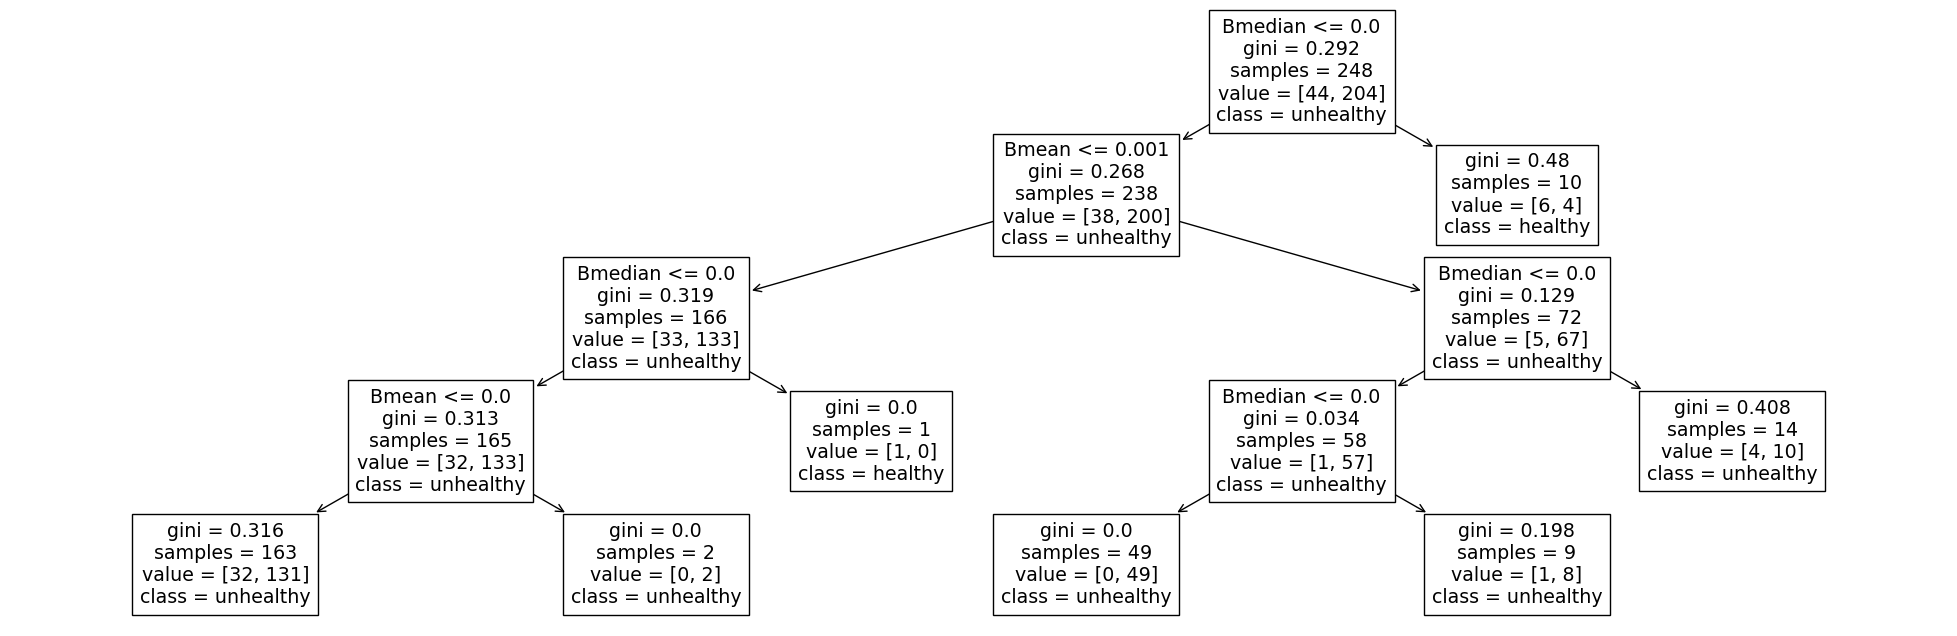

In [50]:
visualize_model(dtree_model, features, target_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


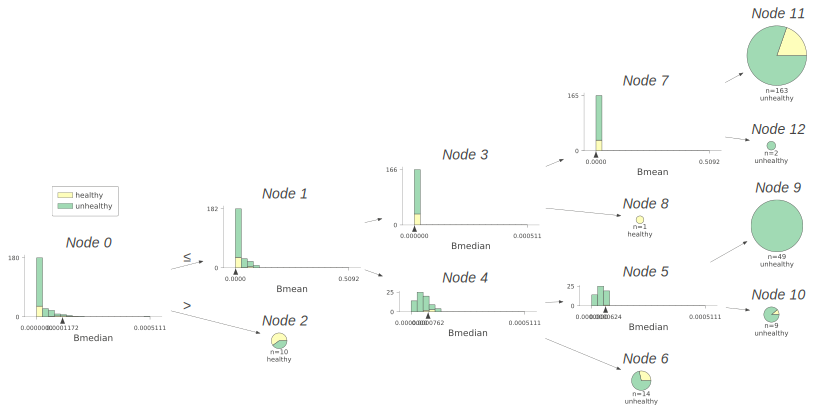

In [52]:
viz = dtreeviz.model(dtree_model,
                    X_train, y_train,
                    feature_names = features,
                    class_names = list(target_labels))

viz.view(orientation = 'LR',
        show_node_labels = True)

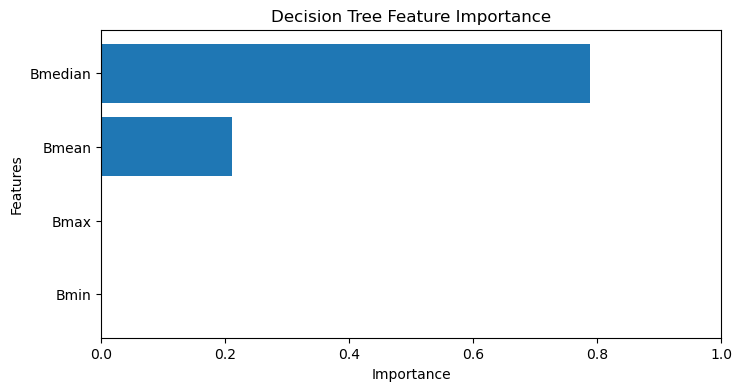

In [53]:
visualize_feature_importance(dtree_model, features)

In [54]:
ccp_alphas, impurities = calculate_pruning_path(sampled_features, diagnoses)
dtree_best = tune_model(X_train, y_train, ccp_alphas)
dtree_best

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0018115942028985507; total time=   0.0s
[CV] END ....................ccp_alpha=0.0018115

DecisionTreeClassifier(ccp_alpha=0.004294149221685452)

In [55]:
cross_validation(sampled_features, diagnoses, dtree_best)

Cross-Validation error


,fit_time,score_time,test_ACC,test_bal_ACC
0,0.004699,0.004488,0.734940,0.474510
1,0.004166,0.005202,0.819277,0.500000
2,0.004497,0.004048,0.771084,0.496569
3,0.003587,0.003820,0.831325,0.533333
4,0.003614,0.003945,0.829268,0.500000




test_ACC        0.797179
test_bal_ACC    0.500882
dtype: float64


In [56]:
dtree_best.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.004294149221685452)

In [57]:
predictions = test_model(X_val, y_val, dtree_best)
calculate_accuracies(y_val, predictions)
calculate_f1(y_val, predictions)
generate_classification_report(y_val, predictions, target_labels)

ACC: 0.8133
Bal. ACC: 0.5353
F1: 0.8949
              precision    recall  f1-score   support

     healthy       0.43      0.10      0.16        30
   unhealthy       0.83      0.97      0.89       136

    accuracy                           0.81       166
   macro avg       0.63      0.54      0.53       166
weighted avg       0.76      0.81      0.76       166



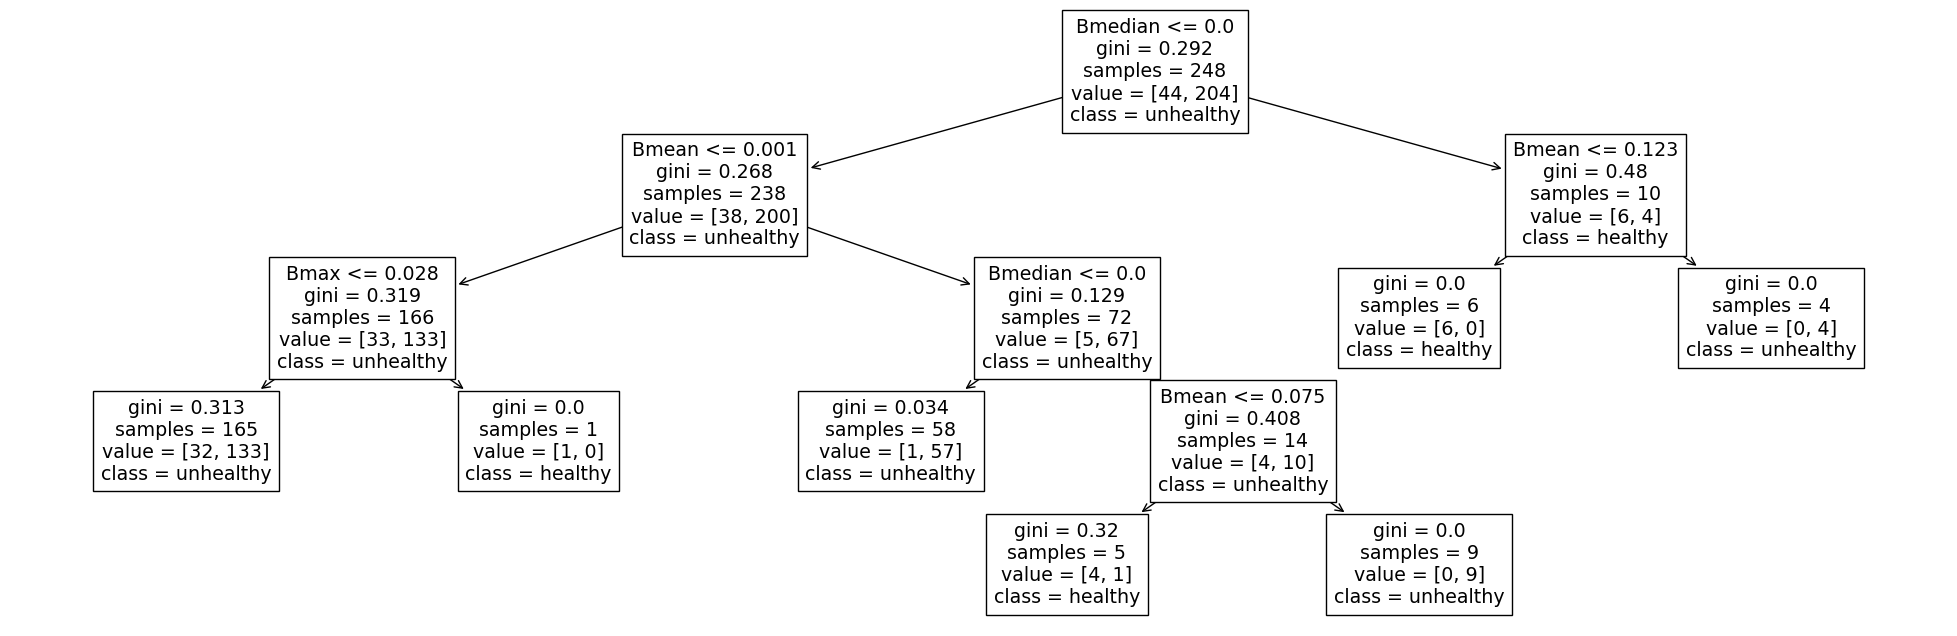

In [58]:
visualize_model(dtree_best, features, target_labels)

The cell below keeps giving me issues so I've commented it out for now

In [60]:
# value = np.random.randint(0, len(X_val))

# x = X_val[value, :]

# print('True Value')
# print(target_labels[y_val[value]])

# viz = dtreeviz.model(dtree_best,
#                     X_train, y_train,
#                     X = x,
#                     feature_names = features,
#                     class_names = list(target_labels))

# viz.view(orientation = 'LR',
#         show_node_labels = True)

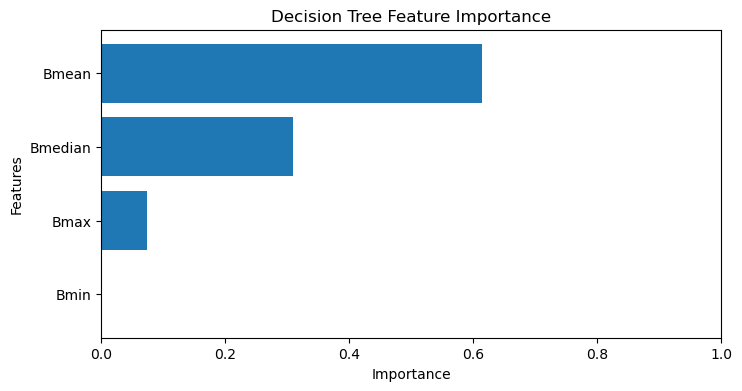

In [61]:
visualize_feature_importance(dtree_best, features)

### TODO: Remove Everything below

In [135]:
max_depth = 7
min_samples_split = 15
max_leaf_nodes = 15

In [136]:
DT_clf = DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split, max_leaf_nodes = max_leaf_nodes)
DT_clf.fit(X_train, y_train)
scoring = {"ACC": 'accuracy'}
cross_validation(sampled_features, targets, DT_clf, scoring, StratifiedKFold(n_splits = 5))
y_predict = DT_clf.predict(X_val)
print('test error')
print('ACC: %.4f' % acc(y_predict, y_val))
print('Bal. ACC: %.4f' %bal_acc(y_predict, y_val))
print('F1: %.4f' % f1(y_predict, y_val, average = 'binary'))
print(classification_report(y_val, y_predict, target_names = label.classes_))

Cross-Validation error


,fit_time,score_time,test_ACC
0,0.003808,0.002227,0.746988
1,0.002539,0.002034,0.807229
2,0.002407,0.001493,0.783133
3,0.002233,0.002043,0.771084
4,0.002336,0.001503,0.829268




test_ACC    0.78754
dtype: float64
test error
ACC: 0.8193
F1: 0.8193
              precision    recall  f1-score   support

     healthy       0.50      0.07      0.12        30
   unhealthy       0.83      0.99      0.90       136

    accuracy                           0.82       166
   macro avg       0.66      0.53      0.51       166
weighted avg       0.77      0.82      0.76       166



[Text(0.5769230769230769, 0.9166666666666666, 'Bmedian <= 0.0\ngini = 0.292\nsamples = 248\nvalue = [44, 204]\nclass = unhealthy'),
 Text(0.38461538461538464, 0.75, 'Bmax <= 0.001\ngini = 0.27\nsamples = 230\nvalue = [37, 193]\nclass = unhealthy'),
 Text(0.23076923076923078, 0.5833333333333334, 'Bmedian <= 0.0\ngini = 0.319\nsamples = 166\nvalue = [33, 133]\nclass = unhealthy'),
 Text(0.15384615384615385, 0.4166666666666667, 'Bmax <= 0.0\ngini = 0.313\nsamples = 165\nvalue = [32, 133]\nclass = unhealthy'),
 Text(0.07692307692307693, 0.25, 'gini = 0.316\nsamples = 163\nvalue = [32, 131]\nclass = unhealthy'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = unhealthy'),
 Text(0.3076923076923077, 0.4166666666666667, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = healthy'),
 Text(0.5384615384615384, 0.5833333333333334, 'Bmedian <= 0.0\ngini = 0.117\nsamples = 64\nvalue = [4, 60]\nclass = unhealthy'),
 Text(0.46153846153846156, 0.4166666666666667, 'gini 

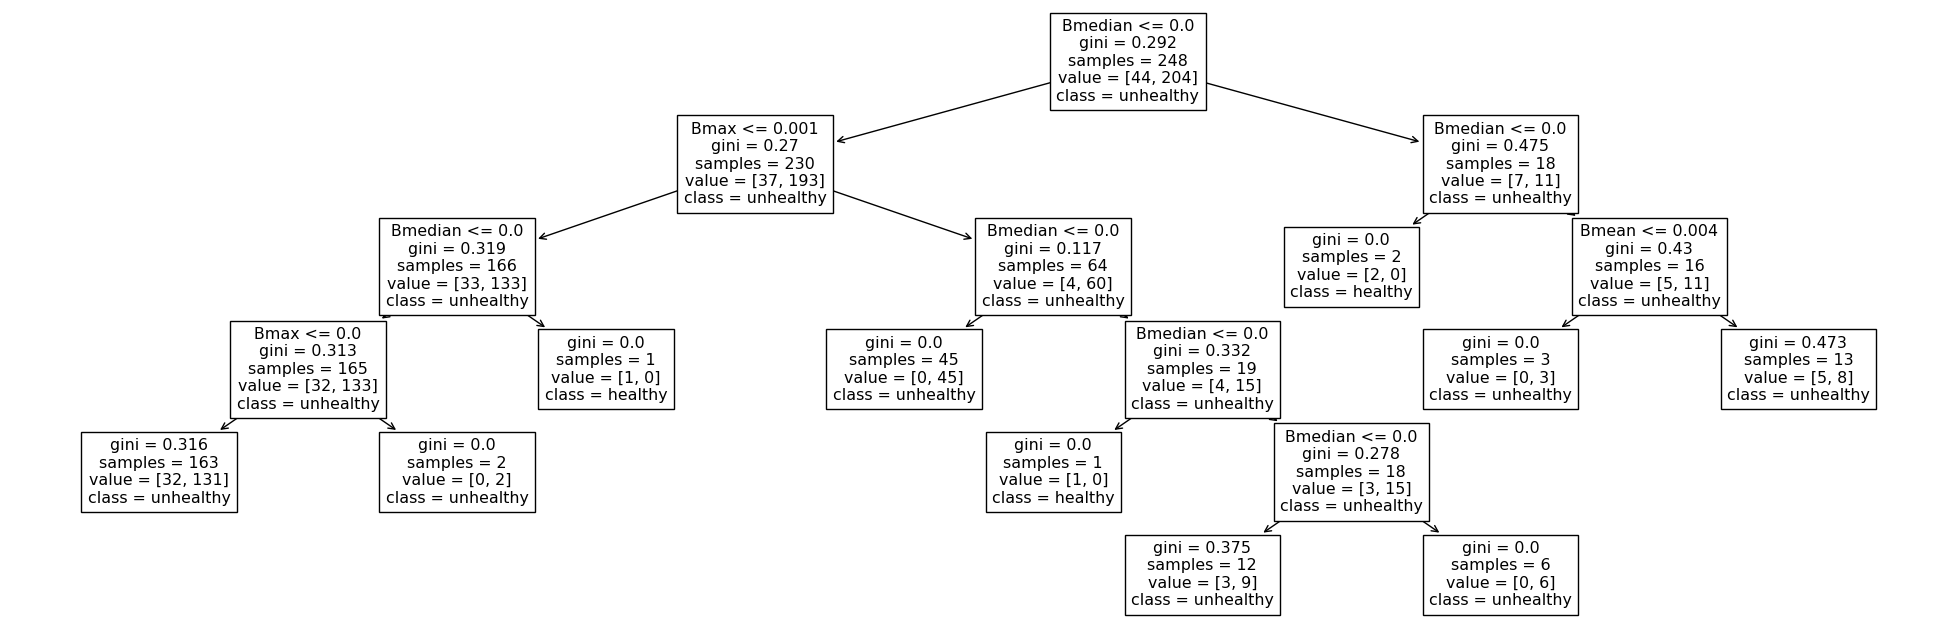

In [137]:
plt.figure(figsize = (25, 8))
tree.plot_tree(DT_clf, feature_names = feature_names, class_names = label.classes_)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


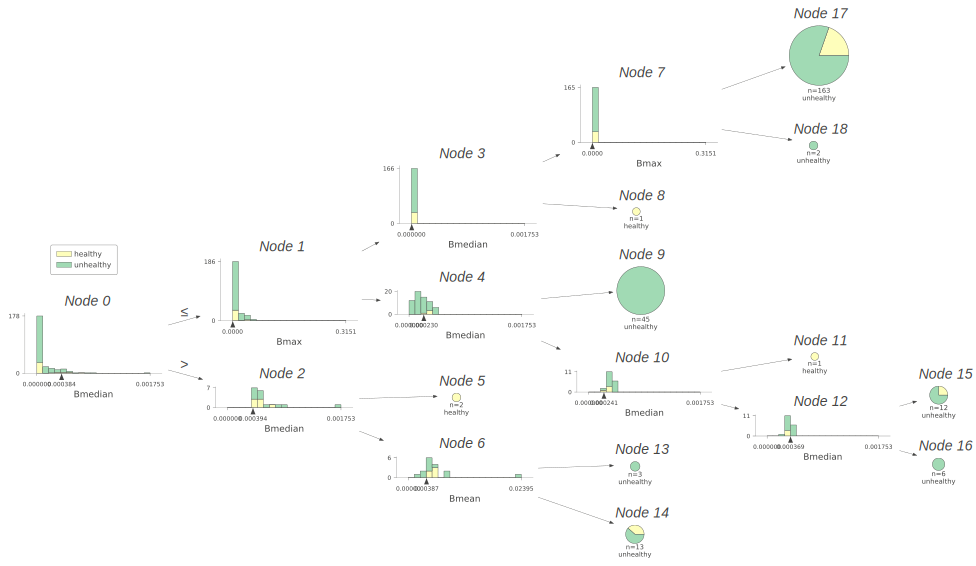

In [138]:
viz = dtreeviz.model(DT_clf,
               X_train, y_train,
               feature_names=feature_names,
               class_names=list(label.classes_),
#                orientation='LR',
#                show_node_labels = True,
#                colors={'classes':((),   # 0 classes
#                                   (),   # 1 class
#                                   (),   # 2 classes
#                                   ('#ff0000','#00ff00','#0000ff') # 3 classes
#                                   )},
               )
              
viz.view(orientation = 'LR',
        show_node_labels = True)

In [ ]:
DT_clf.feature_importances_

InvalidIndexError: (0      False
1      False
2      False
3      False
4      False
       ...  
409    False
410    False
411    False
412    False
413    False
Name: targets, Length: 414, dtype: bool, 2)

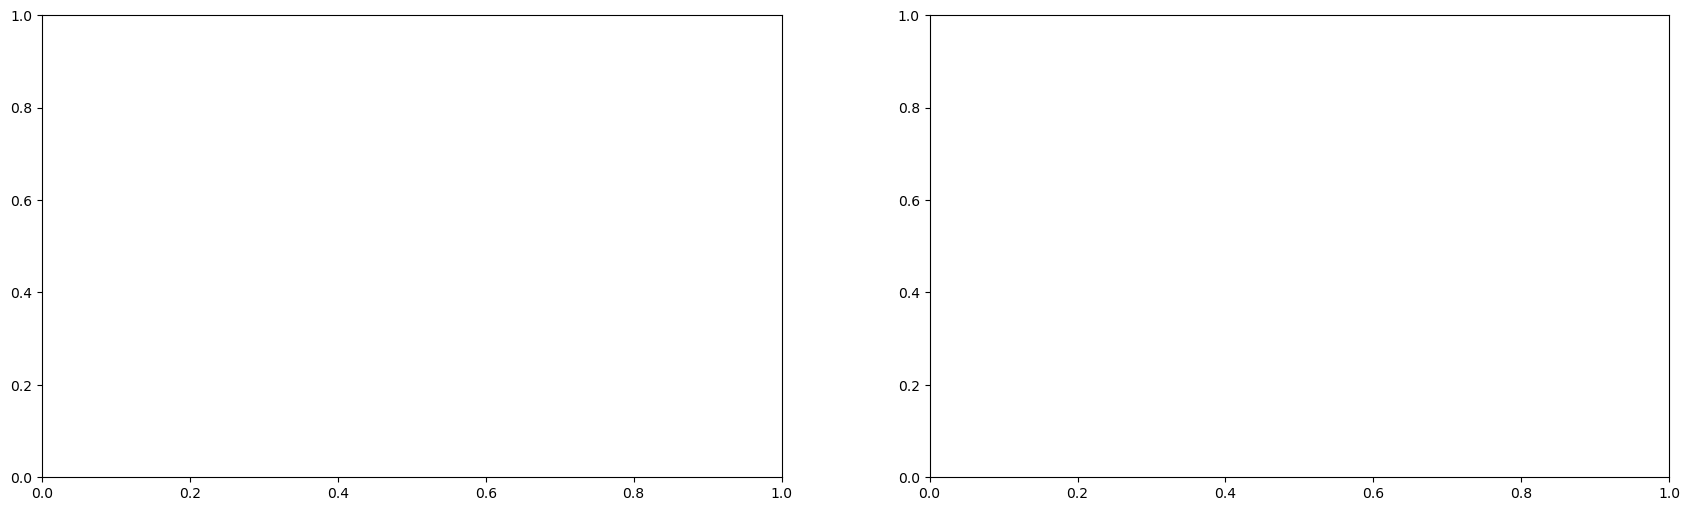

In [153]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[21, 6])

# colors = ['orangered', 'lawngreen']
# ax1.plot(sampled_features[targets == 0, 2], sampled_features[targets == 0, 3], "o", color=colors[0])
# ax1.plot(sampled_features[targets == 1, 2], sampled_features[targets == 1, 3], "^", color=colors[1])
# ax1.set_xlabel(feature_names[2])
# ax1.set_ylabel(feature_names[3])

# artists = tree.plot_tree(DT_clf, feature_names=feature_names, class_names=target_labels,
#                          filled=True, rounded=True, ax=ax2)


InvalidIndexError: (slice(None, None, None), 2)

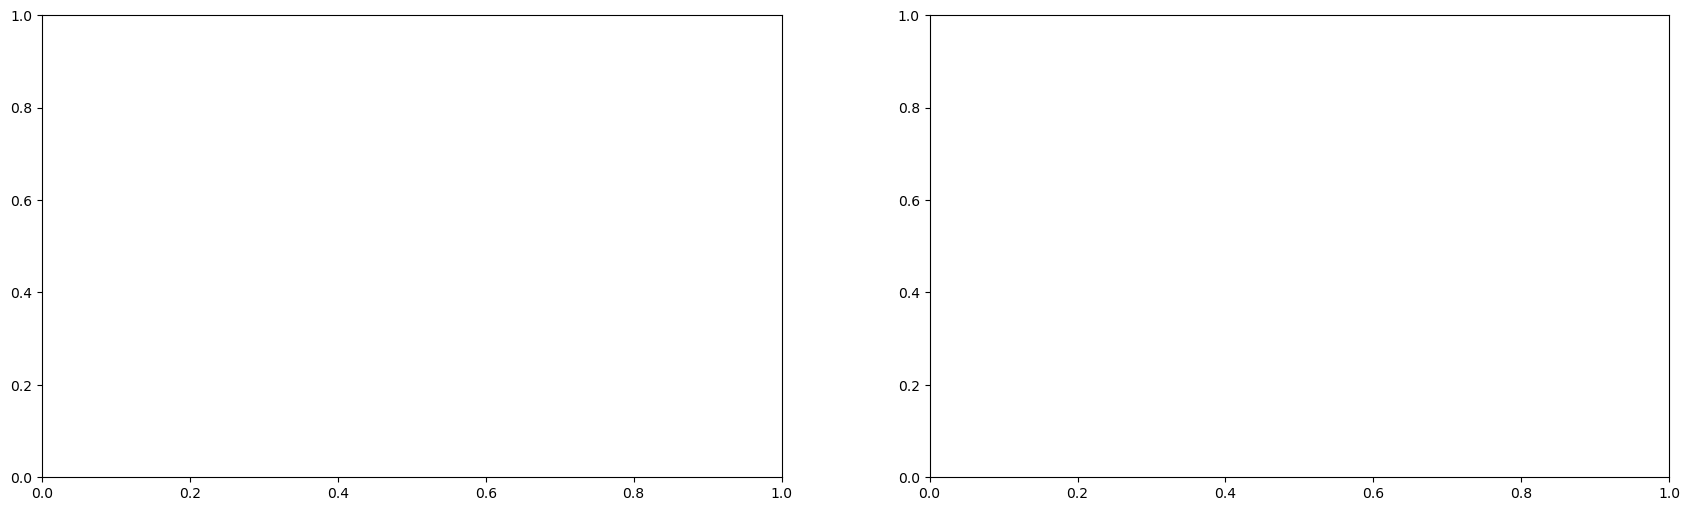

In [139]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[21, 6])

# colors = ['orangered',  'lawngreen', 'purple']
# ax1.plot(sampled_features[:, 2][targets == 0], sampled_features[:, 3][targets == 0], "o", color=colors[0])
# ax1.plot(sampled_features[:, 2][targets == 1], sampled_features[:, 3][targets == 1], "^", color=colors[1])
# ax1.plot(sampled_features[:, 2][targets == 2], sampled_features[:, 3][targets == 2], "d", color=colors[2])
# ax1.set_xlabel(feature_names[2])
# ax1.set_ylabel(feature_names[3])

# artists = tree.plot_tree(DT_clf, feature_names=feature_names, class_names=labels.classes_,
#                          filled=True, rounded=True, ax=ax2)

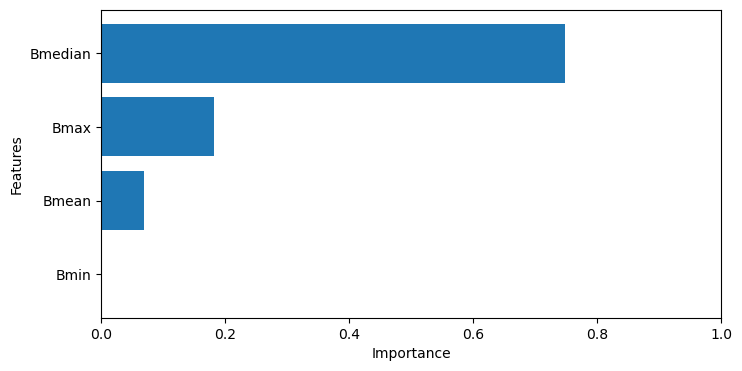

In [140]:
feature_importance = DT_clf.feature_importances_
features_names = np.array(feature_names)
sorted = np.argsort(feature_importance)

ypos = np.arange(len(features_names))

fig= plt.figure(figsize=(8,4))
plt.barh(ypos, feature_importance[sorted])
plt.xlim([0,1])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.yticks(ypos,features_names[sorted] );

### GridSearch Hyperparameter optimization

In [141]:
X = sampled_features.values
y = targets

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4,stratify = y, random_state=42)

In [142]:
DT_clf = DecisionTreeClassifier()
path = DT_clf.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

tuned_parameters = {'ccp_alpha': ccp_alphas[:-1]}



DT_clf_search = GridSearchCV(estimator = DT_clf,
                          param_grid=tuned_parameters ,
                          cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42),
                          verbose=2)


DT_clf_search.fit(X_train, y_train)

DT_clf_best=DT_clf_search.best_estimator_

DT_clf_best.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ......................................ccp_alpha=0.0; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0005231073371294304; total time=   0.0s
[CV] END ....................ccp_alpha=0.0020128824476650566; total time=   0.0s
[CV] END ....................ccp_alpha=0.0020128

In [143]:
scoring = {'ACC': 'accuracy',}


cross_validation (X, y, DT_clf_best, 
                  scoring, StratifiedKFold(n_splits=5)) 

Cross-Validation error


,fit_time,score_time,test_ACC
0,0.002168,0.000984,0.759036
1,0.001633,0.001053,0.819277
2,0.001690,0.000750,0.807229
3,0.001475,0.000799,0.783133
4,0.001531,0.000906,0.829268




test_ACC    0.799589
dtype: float64


In [144]:
DT_clf_best.fit(X_train, y_train)

y_predict=DT_clf_best.predict(X_test)

print('test error')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test,average='micro'))
print('F1 : %.4f' %  f1(y_predict,y_test,average='macro'))
print (classification_report(y_test, y_predict, target_names=label.classes_))

test error
ACC: 0.8253
F1 : 0.8253
F1 : 0.4841
              precision    recall  f1-score   support

     healthy       1.00      0.03      0.06        30
   unhealthy       0.82      1.00      0.90       136

    accuracy                           0.83       166
   macro avg       0.91      0.52      0.48       166
weighted avg       0.86      0.83      0.75       166



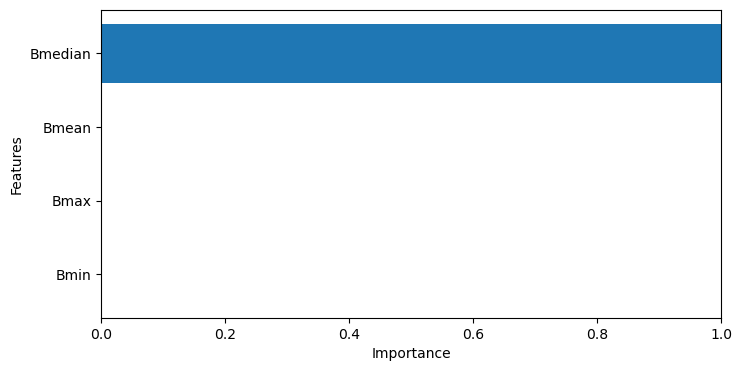

In [145]:
feature_importance = DT_clf_best.feature_importances_
features_names = np.array(feature_names)
sorted = np.argsort(feature_importance)

ypos = np.arange(len(features_names))

fig= plt.figure(figsize=(8,4))
plt.barh(ypos, feature_importance[sorted])
plt.xlim([0,1])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.yticks(ypos,features_names[sorted] );

In [146]:
value = np.random.randint(0, len(X_test))

x = X_test[value,:]

print('True Value')
print(label.classes_[y_test[value]])

viz = dtreeviz.model(DT_clf_best,
               X_train, y_train,
               X = x,
               feature_names=feature_names,
               class_names=list(label.classes_),
#                orientation='LR',
#                show_node_labels = True,
#                colors={'classes':((),   # 0 classes
#                                   (),   # 1 class
#                                   (),   # 2 classes
#                                   ('#ff0000','#00ff00','#0000ff') # 3 classes
#                                   )},
               )
              
viz.view(orientation = 'LR',
        show_node_labels = True)

True Value


KeyError: 82

In [ ]:
def train_model(X_train, y_train, max_depth, min_samples_split, max_leaf_nodes):
    DT_clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, max_leaf_nodes=max_leaf_nodes)
    DT_clf.fit(X_train, y_train)
    return DT_clf

def perform_cross_validation(X, y, model, scoring, cv):
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    return scores

def test_model(model, X_test, y_test):
    y_predict = model.predict(X_test)
    return y_predict

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def calculate_f1(y_true, y_pred, average='binary'):
    return f1_score(y_true, y_pred, average=average)

def generate_classification_report(y_true, y_pred, labels):
    return classification_report(y_true, y_pred, target_names=labels)

def visualize_decision_tree(model, feature_names, class_names):
    plt.figure(figsize=(25, 8))
    tree.plot_tree(model, feature_names=feature_names, class_names=class_names)
    plt.show()

def visualize_decision_tree_dtreeviz(model, X_train, y_train, feature_names, class_names):
    viz = dtreeviz.model(
        DT_clf,
        X_train, y_train,
        feature_names=feature_names,
        class_names=list(class_names)
    )
    viz.view(orientation='LR', show_node_labels=True)

def save_model(model, filename):
    joblib.dump(model, filename)

def load_model(filename):
    return joblib.load(filename)


In [ ]:
pipeline = Pipeline([
    ('train', train_model),
    ('cross_val', perform_cross_validation),
    ('test', test_model),
    ('accuracy', calculate_accuracy),
    ('f1', calculate_f1),
    ('classification_report', generate_classification_report),
    ('visualize_tree', visualize_decision_tree),
    ('visualize_tree_dtreeviz', visualize_decision_tree_dtreeviz),
    ('save_model', save_model),
    ('load_model', load_model)
])


In [ ]:
pipeline.fit(X_train, y_train)

# Access the trained model
model = pipeline.named_steps['train']

# Perform cross-validation
scores = pipeline.named_steps['cross_val'](X, y, model, scoring, StratifiedKFold(n_splits=5))

# Test the model
y_predict = pipeline.named_steps['test'](model, X_val, y_val)

# Calculate accuracy and F1 score
accuracy = pipeline.named_steps['accuracy'](y_val, y_predict)
f1 = pipeline.named_steps['f1'](y_val, y_predict, average='micro')

# Generate classification report
report = pipeline.named_steps['classification_report'](y_val, y_predict, label.classes_)

# Visualize the decision tree
pipeline.named_steps['visualize_tree'](model, feature_names, label.classes_)

# Visualize the decision tree using dtreeviz
pipeline.named_steps['visualize_tree_dtreeviz'](model, X_train, y_train, feature_names, label.classes_)

# Save the model
pipeline.named_steps['save_model'](model, 'model.pkl')

# Load the model
loaded_model = pipeline.named_steps['load_model']('model.pkl')
